In [2]:
import json
from typing import List

# TODO: Add pathlib, p.glob('**/*') to get all files in a folder
import os
import subprocess
import shutil
from pathlib import Path
from tqdm.notebook import tqdm
from collections import defaultdict
from interruptingcow import timeout
from concurrent.futures import ThreadPoolExecutor, as_completed


tmp_dir = "tmprepo"


def read_jsonl(file_path) -> List[dict]:
    with open(file_path, "r") as f:
        lines = f.readlines()
    return [json.loads(line) for line in lines]


def is_github_url(url: str) -> bool:
    return "github.com" in url


def git_clone(url: str, folder: str) -> bool:
    if os.path.exists(folder):
        return True
    res = subprocess.run(
        ["git", "clone", url, folder, "--quiet"],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL,
    )
    return res.returncode == 0


def find_java_files_grep(folder_path, search_string="", exclude_dirs=[]):
    command = [
        "grep",
        "-rlF",
        "--max-count=1",
        "--include=*.java",
        search_string,
        folder_path,
    ]
    for dir_name in exclude_dirs:
        command.extend(["--exclude-dir", dir_name])
    result = subprocess.run(command, stdout=subprocess.PIPE, text=True)
    return result.stdout.splitlines()


def search_string_in_files(folder_path, search_string):
    """
    Recursively searches for a string in all files within a folder and its subfolders.

    Args:
        folder_path (str): The path to the folder to search in.
        search_string (str): The string to search for.

    Returns:
        list: A list of file paths containing the search string.
    """
    excluded_parts = [".git", "dists", "resource", "com", "org", "net"]
    matching_files = []
    # for root, _, files in os.walk(folder_path):
    #     for file in files:
    #         if not file.endswith(".java"):
    #             continue
    #         file_path = os.path.join(root, file)
    #         if any(ex in file_path for ex in exclude_parts):
    #             continue
    #         with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    #             if search_string in f.read():
    #                 matching_files.append(file_path)

    files = find_java_files_grep(
        folder_path, search_string, exclude_dirs=excluded_parts
    )
    matching_files = files
    # files = filter(lambda e: not any(ex in e for ex in excluded_parts), files)
    # for file in files:
    #     with open(file, 'r', encoding='utf-8', errors='ignore') as f:
    #         if search_string in f.read():
    #             matching_files.append(file)
    return matching_files


def exec(bug: str):
    bug_solution_str = bug_solution_str_map[bug]
    uris = bug_uri_map[bug]
    for uri in uris:
        label = uri_tag_map[uri]
        tmp_repo_path = os.path.join(tmp_dir, label)
        # # Check if repo already exists and is a valid repo
        # if not os.path.exists(tmp_repo_path):
        #     # Clone repository
        #     success = git_clone(uri, tmp_repo_path)
        #     if not success:
        #         return

        # Check for string in tmp_path
        if not os.path.exists(tmp_repo_path):
            continue

        matching_files = search_string_in_files(tmp_repo_path, bug_solution_str)
        if not matching_files:
            continue
        repo_file_matches[bug].append(label)

In [29]:
# Generate mappings between bugs and repositories

benchmarks = [
    ("humaneval-java", "data/humaneval-java/candidates_HumanEvalJava_sigonly-instruct_google_model_name=gemini-1.5-flash_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10.jsonl"),
    ("defects4j", "data/defects4j/candidates_Defects4J_sigonly-instruct_google_model_name=gemini-1.5-flash_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10.jsonl"),
    ("gitbug-java", "data/gitbug-java/candidates_GitBugJava_sigonly-instruct_google_model_name=gemini-1.5-flash_max_length=4096_temperature=0.05_generation_strategy=sampling_num_return_sequences=10.jsonl"),
]

uri_cache = set()
uri_tag_map = {}  # repo_uri -> repo_tag
bugs_with_sources = []  # List of bug ids
all_bugs = []
bug_uri_map = defaultdict(list)  # bug_id -> [repo_uri]
bug_solution_str_map = {}  # bug_id -> fixed_bug_str
for benchmark_label, path in benchmarks:
    data = read_jsonl(path)
    for d in tqdm(data, desc="Generate bug and repo uri mappings"):
        bug_id = f"{benchmark_label}-{d['identifier']}"
        all_bugs.append(bug_id)
        # Get bug to fix string mapping
        fixed_code = d["fixed_code"]
        if not fixed_code:
            continue
        bug_solution_str_map[bug_id] = fixed_code

        # Get github urls
        generations = d.get("generation", None)
        if not generations:
            continue
        candidates = generations[0]["candidates"][0]
        # If no matches, skip
        if not "citation_metadata" in candidates:
            continue
        sources = candidates["citation_metadata"]["citation_sources"]
        # Go though sources
        for source in sources:
            # If source has no uri or is not a github url, skip
            if not "uri" in source:
                continue
            uri: str = source["uri"]
            if not is_github_url(uri):
                continue
            if uri in uri_cache:
                continue
            uri_cache.add(uri)
            # Create repo tag
            repo_tag = uri.removeprefix("https://github.com/")
            repo_tag = repo_tag.removesuffix(".git")
            repo_tag = repo_tag.replace("/", "_")
            uri_tag_map[uri] = repo_tag
            # Add repo uri match to bug
            bug_uri_map[bug_id].append(uri)
        
        # Add bug to list of bugs with repos to be scanned if there are any repos
        if not bug_uri_map[bug_id]:
            continue
        bugs_with_sources.append(bug_id)


Generate bug and repo uri mappings:   0%|          | 0/163 [00:00<?, ?it/s]

Generate bug and repo uri mappings:   0%|          | 0/835 [00:00<?, ?it/s]

Generate bug and repo uri mappings:   0%|          | 0/199 [00:00<?, ?it/s]

In [30]:
from functools import reduce
# Get all tags

dirs = set(os.listdir(tmp_dir))
uris = list(filter(lambda e: uri_tag_map[e] not in dirs, uri_tag_map.keys()))

# Clone repos
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(git_clone, uri, os.path.join(tmp_dir, uri_tag_map[uri])): uri for uri in uris}
    for future in tqdm(as_completed(futures), total=len(uris), desc="Download .git repositories"):
        future.result()


Download .git repositories:   0%|          | 0/27 [00:00<?, ?it/s]

In [31]:
# Execute search on repositories mapped to bugs

# Path to cache file
CACHE_FILE = "bug_repo_matches_cache.json"

# Load cache if it exists
if os.path.exists(CACHE_FILE):
    with open(CACHE_FILE, "r") as cache_file:
        cached_data = json.load(cache_file)
    repo_file_matches = defaultdict(list, cached_data)
    print(f"Read cached results from {len(repo_file_matches)} bugs")
else:
    repo_file_matches = defaultdict(list)

with ThreadPoolExecutor() as executor:
    bugs_with_matches = list(filter(lambda e: e not in repo_file_matches, bugs_with_sources))
    futures = {executor.submit(exec, bug): bug for bug in bugs_with_matches}
    for future in tqdm(as_completed(futures), total=len(bugs_with_matches), desc="Search for bug solution instances in repositories"):
        future.result()

with open(CACHE_FILE, "w") as cache_file:
    json.dump(repo_file_matches, cache_file)

Search for bug solution instances in repositories:   0%|          | 0/170 [00:00<?, ?it/s]

In [27]:
repo_file_matches

defaultdict(list,
            {'defects4j-Compress-44': ['dunkbing_l3arn_cpp',
              'cloud-software-foundation_c5-replicator'],
             'defects4j-JacksonDatabind-62': ['FasterXML_jackson-databind'],
             'defects4j-Jsoup-39': ['it-objects_android-string-extractor-plugin',
              'mahersafadi_ClassDiagramGenerator'],
             'defects4j-Math-3': ['pborczyk_classification'],
             'defects4j-Jsoup-34': ['jhy_jsoup'],
             'defects4j-Cli-40': ['jimyip_curl2java', 'asdliaosheng_miaosha'],
             'defects4j-JacksonDatabind-84': ['nemo0110_LeetCode'],
             'defects4j-Math-78': ['sameeragarwal_blinkdb'],
             'defects4j-Compress-24': ['lockapp_androidapp'],
             'defects4j-JacksonDatabind-71': ['joongsoo_jackson-module-force-deserializer'],
             'defects4j-Chart-1': ['boyang9602_APR_resources'],
             'defects4j-Closure-71': ['replit-archive_jsrepl'],
             'defects4j-Compress-1': ['isstac_bad

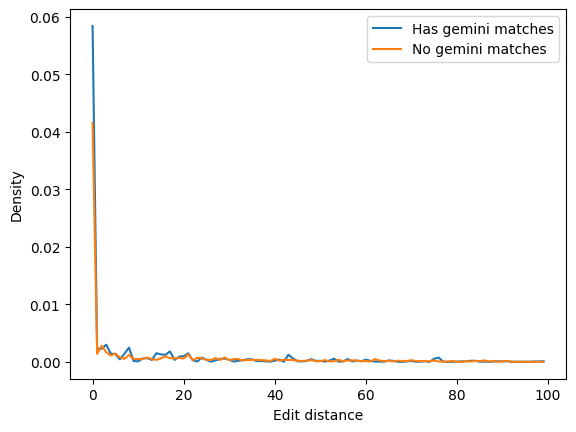

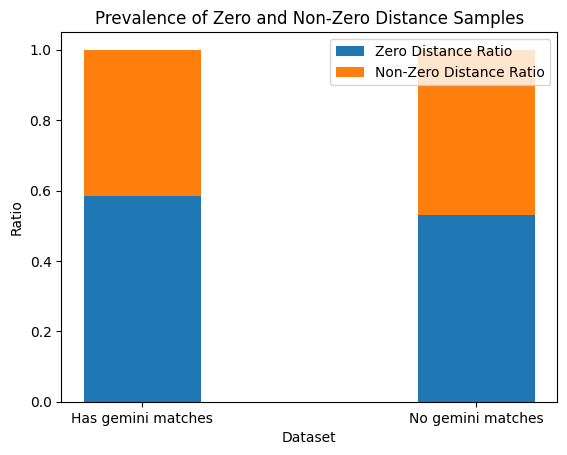

In [24]:
# Group bugs into a single aggregate benchmark of flagged and non-flagged bugs
from functools import reduce
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Tuple
import numpy as np


bugs_all_set = set(all_bugs)
bugs_exact_match_set = set(repo_file_matches.keys())

# Get CDD score from bugs in each bucket

CDD_DATA_CACHE = "cdd-data-cache.json"

with open(CDD_DATA_CACHE, "r") as f:
    data: dict = json.loads(f.read())

gemini_match_dists = []
gemini_no_match_dists = []
for k, v in data.items():
    if k in bugs_exact_match_set:
        gemini_match_dists.append(v)
    else:
        gemini_no_match_dists.append(v)

d_full = filter(None, gemini_match_dists)  # Remove None values
d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
d_full = list(d_full)
total = sum(d_full)
count = Counter(d_full)
x, y = zip(*sorted(count.items(), key=lambda x: x[0]))
y = [c / total for c in y]
plt.plot(x, y, label="Has gemini matches")

d_full = filter(None, gemini_no_match_dists)  # Remove None values
d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
d_full = list(d_full)
total = sum(d_full)
count = Counter(d_full)
x, y = zip(*sorted(count.items(), key=lambda x: x[0]))
y = [c / total for c in y]
plt.plot(x, y, label="No gemini matches")

plt.xlabel("Edit distance")
plt.ylabel("Density")
plt.legend()

plt.show()

# Bar chart

identifiers = ["Has gemini matches", "No gemini matches"]
index = np.arange(len(identifiers))  # The label locations

zero_distance_ratios = []
non_zero_distance_ratios = []

# for i, dists in enumerate(dists_list):
#     d_full = filter(None, dists)  # Remove None values
#     d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
#     d_full = list(d_full)
#     count = Counter(d_full)
    
#     zero_distance = count.get(0, 0)
#     total_samples = sum(count.values())
    
#     zero_distance_ratio = zero_distance / total_samples
#     non_zero_distance_ratio = 1 - zero_distance_ratio
    
#     zero_distance_ratios.append(zero_distance_ratio)
#     non_zero_distance_ratios.append(non_zero_distance_ratio)

# Has gemeni matches

d_full = filter(None, gemini_match_dists)  # Remove None values
d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
d_full = list(d_full)
count = Counter(d_full)

zero_distance = count.get(0, 0)
total_samples = sum(count.values())

zero_distance_ratio = zero_distance / total_samples
non_zero_distance_ratio = 1 - zero_distance_ratio

zero_distance_ratios.append(zero_distance_ratio)
non_zero_distance_ratios.append(non_zero_distance_ratio)

# No gemeni matches

d_full = filter(None, gemini_no_match_dists)  # Remove None values
d_full = reduce(lambda x, y: x + y, d_full)  # Flatten the list
d_full = list(d_full)
count = Counter(d_full)

zero_distance = count.get(0, 0)
total_samples = sum(count.values())

zero_distance_ratio = zero_distance / total_samples
non_zero_distance_ratio = 1 - zero_distance_ratio

zero_distance_ratios.append(zero_distance_ratio)
non_zero_distance_ratios.append(non_zero_distance_ratio)

# Plot

fig, ax = plt.subplots()
bar_width = 0.35

p1 = ax.bar(index, zero_distance_ratios, bar_width, label='Zero Distance Ratio')
p2 = ax.bar(index, non_zero_distance_ratios, bar_width, bottom=zero_distance_ratios, label='Non-Zero Distance Ratio')

ax.set_xlabel('Dataset')
ax.set_ylabel('Ratio')
ax.set_title('Prevalence of Zero and Non-Zero Distance Samples')
ax.set_xticks(index)
ax.set_xticklabels(identifiers)
ax.legend()

plt.show()
